# Introduction

Here's another example that you may want to develop into an application. The goal is to predict whether a client will default on their credit card payment given a set of features about the client and their previous credit card behavior. 

> **Your turn!** See if you can use the model trained below as part of a web application for credit card default prediction. Feel free to try to improve the model first.

# Get the data

In [ ]:
from pycaret.datasets import get_data

In [5]:
#get_data()

In [ ]:
df = get_data('credit')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  24000 non-null  int64  
 1   SEX        24000 non-null  int64  
 2   EDUCATION  24000 non-null  int64  
 3   MARRIAGE   24000 non-null  int64  
 4   AGE        24000 non-null  int64  
 5   PAY_1      24000 non-null  int64  
 6   PAY_2      24000 non-null  int64  
 7   PAY_3      24000 non-null  int64  
 8   PAY_4      24000 non-null  int64  
 9   PAY_5      24000 non-null  int64  
 10  PAY_6      24000 non-null  int64  
 11  BILL_AMT1  24000 non-null  float64
 12  BILL_AMT2  24000 non-null  float64
 13  BILL_AMT3  24000 non-null  float64
 14  BILL_AMT4  24000 non-null  float64
 15  BILL_AMT5  24000 non-null  float64
 16  BILL_AMT6  24000 non-null  float64
 17  PAY_AMT1   24000 non-null  float64
 18  PAY_AMT2   24000 non-null  float64
 19  PAY_AMT3   24000 non-null  float64
 20  PAY_AM

Here's a description of the features, copied from https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset.

```

    ID: ID of each client
    LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
    SEX: Gender (1=male, 2=female)
    EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
    MARRIAGE: Marital status (1=married, 2=single, 3=others)
    AGE: Age in years
    PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
    PAY_2: Repayment status in August, 2005 (scale same as above)
    PAY_3: Repayment status in July, 2005 (scale same as above)
    PAY_4: Repayment status in June, 2005 (scale same as above)
    PAY_5: Repayment status in May, 2005 (scale same as above)
    PAY_6: Repayment status in April, 2005 (scale same as above)
    BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
    BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
    BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
    BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
    BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
    BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
    PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
    PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
    PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
    PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
    PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
    PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
    default.payment.next.month: Default payment (1=yes, 0=no)

```

Note that the data set is highly imbalanced (most customers won't default on their payments).

In [9]:
df.default.value_counts()

0    18694
1     5306
Name: default, dtype: int64

We'll deal with this issue when setting up the data and the problem below.

# Prepare data

In [6]:
from pycaret.classification import *

We will make sure to do stratified splitting during our cross-validation and when splitting off a test set. We'll also use the [SMOTE method](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn) to deal with the class imbalance during model training. 

In [10]:
clf = setup(df, target = 'default', data_split_stratify=True, fix_imbalance=True)

,Description,Value
0,session_id,7311
1,Target,default
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(24000, 24)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


# Modelling

Let's find the top performing models from those in PyCaret:

In [11]:
top5 = compare_models(n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8189,0.7723,0.3710,0.6612,0.4749,0.3759,0.3990,0.1320
gbc,Gradient Boosting Classifier,0.8187,0.7749,0.3654,0.6638,0.4709,0.3725,0.3969,1.0630
ada,Ada Boost Classifier,0.8186,0.7596,0.3799,0.6555,0.4806,0.3801,0.4011,0.2510
catboost,CatBoost Classifier,0.8164,0.7726,0.3718,0.6475,0.4719,0.3706,0.3917,2.5110
rf,Random Forest Classifier,0.8120,0.7583,0.3815,0.6221,0.4726,0.3662,0.3826,0.2170
xgboost,Extreme Gradient Boosting,0.8095,0.7518,0.3640,0.6174,0.4578,0.3515,0.3697,0.6150
et,Extra Trees Classifier,0.8027,0.7364,0.3767,0.5835,0.4574,0.3437,0.3562,0.2120
lda,Linear Discriminant Analysis,0.7768,0.7586,0.5498,0.4959,0.5214,0.3764,0.3773,0.1280
ridge,Ridge Classifier,0.7767,0.0000,0.5504,0.4956,0.5214,0.3763,0.3772,0.0440
dt,Decision Tree Classifier,0.7215,0.6121,0.4149,0.3811,0.3971,0.2166,0.2169,0.0740


Here's a VotingRegressor ensemble: 

In [13]:
blender = blend_models(estimator_list = top5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8232,0.7825,0.3666,0.6869,0.4780,0.3832,0.4107
1,0.8268,0.7656,0.3747,0.7020,0.4886,0.3957,0.4240
2,0.8167,0.7789,0.3558,0.6567,0.4615,0.3626,0.3874
3,0.8274,0.8018,0.4151,0.6784,0.5151,0.4174,0.4360
4,0.8167,0.7865,0.4124,0.6296,0.4984,0.3921,0.4053
5,0.8077,0.7635,0.3387,0.6207,0.4383,0.3342,0.3565
6,0.8155,0.7808,0.3629,0.6490,0.4655,0.3646,0.3871
7,0.8161,0.7787,0.3737,0.6465,0.4736,0.3717,0.3922
8,0.8280,0.7758,0.4059,0.6895,0.5110,0.4150,0.4365
9,0.8166,0.7732,0.3639,0.6522,0.4671,0.3669,0.3897


We pick out the best model (including the combinations of single models) we found above:

In [15]:
best = automl()

In [16]:
best

VotingClassifier(estimators=[('lightgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=7311, reg_alpha=0.0,
                                             reg_lambda=0.0, silent='warn'...
                                                     max_depth=None,
                                   

# Evaluate models

In [17]:
preds = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8213,0.7863,0.3832,0.6667,0.4866,0.3878,0.4097


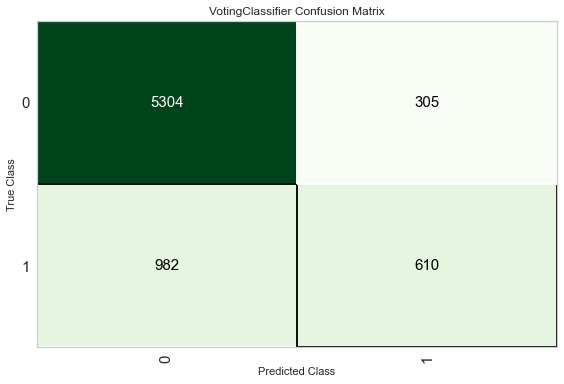

In [18]:
plot_model(best, 'confusion_matrix')

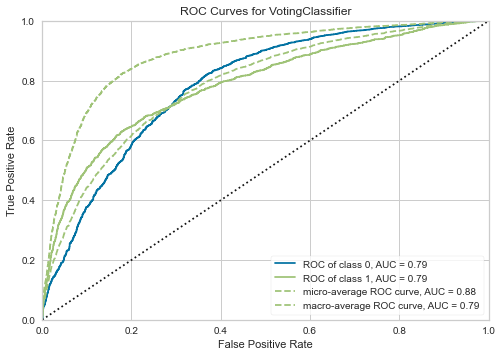

In [19]:
plot_model(best)

> We note that the model's performance isn't that good. For example, when the model predicts that a customer in the test set will default it is only correct twice as often as incorrect. Regardless, we continue.

In [20]:
from sklearn.inspection import permutation_importance

In [21]:
X_test = get_config(variable='X_test')
y_test = get_config(variable='y_test')

In [22]:
r = permutation_importance(best, X_test, y_test)

Here's the ranked list of features accoring to their importance as measured by permutation importance:

In [23]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_test.columns[i]:<8}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

PAY_1_2 0.032 +/- 0.004
LIMIT_BAL0.002 +/- 0.001
PAY_2_2 0.002 +/- 0.000
PAY_1_3 0.001 +/- 0.000
PAY_5_2 0.001 +/- 0.000
PAY_AMT60.001 +/- 0.000
PAY_4_3 0.000 +/- 0.000
PAY_4_6 0.000 +/- 0.000
PAY_5_3 0.000 +/- 0.000


# Export the model

In [ ]:
final_model = finalize_model(best)
save_model(final_model, 'saved_credit_model_161121')